In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
data_path = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 1/data'

In [4]:
import os

folders = ['Bike', 'Car']

for folder in folders:
  folder_path = os.path.join(data_path, folder)
  num_files = 0

  if os.path.exists(folder_path) and os.path.isdir(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            num_files += 1
    print(f'The folder "{folder}" contains {num_files} files.')
  else:
    print(f'The folder "{folder}" does not exist or is not a directory.')


The folder "Bike" contains 200 files.
The folder "Car" contains 200 files.


In [5]:
data_path

'/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 1/data'

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import random
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.transforms import ToTensor, Normalize
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import copy
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from collections import Counter

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

folders = ['Bike', 'Car']
class SquarePad:
    def __call__(self, img):
        w, h = img.size
        max_side = max(w, h)
        new_img = ImageOps.pad(img, (max_side, max_side), color=(256, 256, 256))
        return new_img
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ModifiedAlexNet, self).__init__()
        self.alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        # self.alexnet.classifier[6] = nn.Linear(4096, 2)

        self.alexnet.features = nn.Sequential(*list(self.alexnet.features.children())[:3])
        dummy_input = torch.randn(1, 3, 227, 227)
        # output_size = self.alexnet.features(dummy_input).view(-1).shape[0]
        self.alexnet.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.alexnet.classifier = nn.Sequential(
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, num_classes)
        )

    # def forward(self, x):
    #     return self.alexnet(x)
    def forward(self, x):
        x = self.alexnet.features(x)
        x = self.alexnet.avgpool(x)
        # print(x.shape)  # In kích thước tensor
        x = torch.flatten(x, start_dim=1)
        x = self.alexnet.classifier(x)
        return x


def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        total_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
        test_losses.append(total_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.legend()
    plt.show()


In [11]:
import random
import copy
from collections import Counter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, ConcatDataset, Subset
from PIL import ImageOps

class SquarePad:
    def __call__(self, img):
        w, h = img.size
        max_side = max(w, h)
        new_img = ImageOps.pad(img, (max_side, max_side), color=(256, 256, 256))
        return new_img

# Transform (không Augmentation)
transform = transforms.Compose([
    SquarePad(),
    transforms.Resize((227, 227)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transform (có Augmentation)
transform_aug = transforms.Compose([
    SquarePad(),
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


original_dataset = datasets.ImageFolder(root=data_path)

# Tách chỉ số theo từng class
class_indices = {class_idx: [] for class_idx in range(len(original_dataset.classes))}
for idx, (_, class_idx) in enumerate(original_dataset.samples):
    class_indices[class_idx].append(idx)

train_indices, val_indices, test_indices = [], [], []

for class_idx, indices in class_indices.items():
    random.shuffle(indices)
    total = len(indices)

    test_size = int(0.15 * total)
    val_size = int(0.15 * total)
    train_size = total - test_size - val_size

    test_class_samples = indices[:test_size]
    val_class_samples = indices[test_size:test_size + val_size]
    train_class_samples = indices[test_size + val_size:]

    test_indices.extend(test_class_samples)
    val_indices.extend(val_class_samples)
    train_indices.extend(train_class_samples)

# Shuffle để tránh bias
random.shuffle(train_indices)
random.shuffle(val_indices)
random.shuffle(test_indices)

# Tạo các dataset riêng biệt
train_dataset = copy.deepcopy(original_dataset)
val_dataset = copy.deepcopy(original_dataset)
test_dataset = copy.deepcopy(original_dataset)

train_dataset.samples = [original_dataset.samples[i] for i in train_indices]
val_dataset.samples = [original_dataset.samples[i] for i in val_indices]
test_dataset.samples = [original_dataset.samples[i] for i in test_indices]

train_dataset.transform = transform
val_dataset.transform = transform
test_dataset.transform = transform

# Thống kê
def count_class_distribution(indices, label_source):
    labels = [label_source[i][1] for i in indices]
    return Counter(labels)

print(f"\nTổng số mẫu trong tập Train: {len(train_dataset)}")
print(f"Tổng số mẫu trong tập Validation: {len(val_dataset)}")
print(f"Tổng số mẫu trong tập Test: {len(test_dataset)}")

print("\nSố lượng mẫu mỗi class - Train:")
for k, v in count_class_distribution(train_indices, original_dataset.samples).items():
    print(f"Class {k}: {v} mẫu")

print("\nSố lượng mẫu mỗi class - Validation:")
for k, v in count_class_distribution(val_indices, original_dataset.samples).items():
    print(f"Class {k}: {v} mẫu")

print("\nSố lượng mẫu mỗi class - Test:")
for k, v in count_class_distribution(test_indices, original_dataset.samples).items():
    print(f"Class {k}: {v} mẫu")

# Augmentation
num_augment_copies = 4
aug_datasets = [copy.deepcopy(train_dataset) for _ in range(num_augment_copies)]
for aug_dataset in aug_datasets:
    aug_dataset.transform = transform_aug

# Gộp các dataset augmented
dataset = ConcatDataset([train_dataset] + aug_datasets)

# DataLoaders
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\nTổng số ảnh train (gốc): {len(train_dataset)}, Augmented train: {len(dataset) - len(train_dataset)}, Tổng dataset: {len(dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# Kiểm tra 1 batch
for images, labels in train_loader:
    print("Shape of images:", images.shape)
    break



Tổng số mẫu trong tập Train: 280
Tổng số mẫu trong tập Validation: 60
Tổng số mẫu trong tập Test: 60

Số lượng mẫu mỗi class - Train:
Class 0: 140 mẫu
Class 1: 140 mẫu

Số lượng mẫu mỗi class - Validation:
Class 1: 30 mẫu
Class 0: 30 mẫu

Số lượng mẫu mỗi class - Test:
Class 0: 30 mẫu
Class 1: 30 mẫu

Tổng số ảnh train (gốc): 280, Augmented train: 1120, Tổng dataset: 1400, Validation: 60, Test: 60
Shape of images: torch.Size([32, 3, 227, 227])


Epoch 1/20, Train Loss: 0.6950, Test Loss: 0.6311
Epoch 2/20, Train Loss: 0.6541, Test Loss: 0.6261
Epoch 3/20, Train Loss: 0.6429, Test Loss: 0.5701
Epoch 4/20, Train Loss: 0.6045, Test Loss: 0.5470
Epoch 5/20, Train Loss: 0.5887, Test Loss: 0.5268
Epoch 6/20, Train Loss: 0.5450, Test Loss: 0.4694
Epoch 7/20, Train Loss: 0.5210, Test Loss: 0.4659
Epoch 8/20, Train Loss: 0.4968, Test Loss: 0.4637
Epoch 9/20, Train Loss: 0.5095, Test Loss: 0.4185
Epoch 10/20, Train Loss: 0.5079, Test Loss: 0.4038
Epoch 11/20, Train Loss: 0.4903, Test Loss: 0.3934
Epoch 12/20, Train Loss: 0.4826, Test Loss: 0.4217
Epoch 13/20, Train Loss: 0.4751, Test Loss: 0.4030
Epoch 14/20, Train Loss: 0.4737, Test Loss: 0.3973
Epoch 15/20, Train Loss: 0.4638, Test Loss: 0.3763
Epoch 16/20, Train Loss: 0.4577, Test Loss: 0.4269
Epoch 17/20, Train Loss: 0.4706, Test Loss: 0.3753
Epoch 18/20, Train Loss: 0.4470, Test Loss: 0.3779
Epoch 19/20, Train Loss: 0.4518, Test Loss: 0.3820
Epoch 20/20, Train Loss: 0.4486, Test Lo

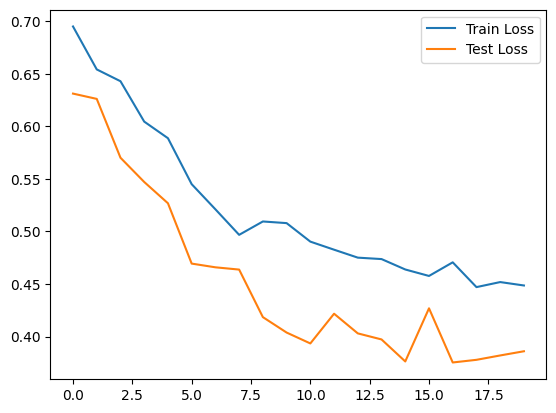

In [30]:
model = ModifiedAlexNet(num_classes=2)
train_and_evaluate(model, train_loader, val_loader, epochs=20, lr = 1e-3)

In [21]:
model = ModifiedAlexNet(num_classes=2)
model

ModifiedAlexNet(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (classifier): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=32, out_features=2, bias=True)
    )
  )
)

In [15]:
alexnet = models.alexnet()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [33]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters ̣(GAP): {total_params}")

total_params = sum(p.numel() for p in alexnet.parameters() if p.requires_grad)
print(f"Total parameters (AlexNet): {total_params}")

Total parameters ̣(GAP): 24370
Total parameters (AlexNet): 61100840


Accuracy: 0.8166666666666667
Precision: 0.8257142857142857
Recall: 0.8166666666666667
F1-score: 0.8153846153846154
              precision    recall  f1-score   support

        Bike       0.88      0.73      0.80        30
         Car       0.77      0.90      0.83        30

    accuracy                           0.82        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60



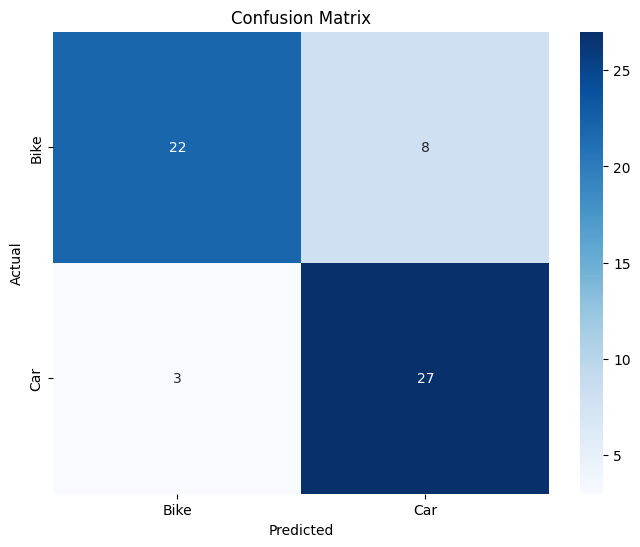

(0.8166666666666667,
 0.8257142857142857,
 0.8166666666666667,
 0.8153846153846154,
 array([[22,  8],
        [ 3, 27]]))

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix , classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    # print(f"Confusion Matrix:\n{conf_matrix}")
    cf = classification_report(y_true, y_pred, target_names=['Bike', 'Car'])
    print(cf)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Bike', 'Car'], yticklabels=['Bike', 'Car'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    return accuracy, precision, recall, f1, conf_matrix

# Assuming 'model' is your trained model and 'test_loader' is your test data loader
# Example usage (replace with your actual model and data loader)
evaluate_model(model, test_loader)


Accuracy: 0.8166666666666667
Precision: 0.8349001175088131
Recall: 0.8166666666666667
F1-score: 0.8141368628555337
              precision    recall  f1-score   support

        Bike       0.91      0.70      0.79        30
         Car       0.76      0.93      0.84        30

    accuracy                           0.82        60
   macro avg       0.83      0.82      0.81        60
weighted avg       0.83      0.82      0.81        60



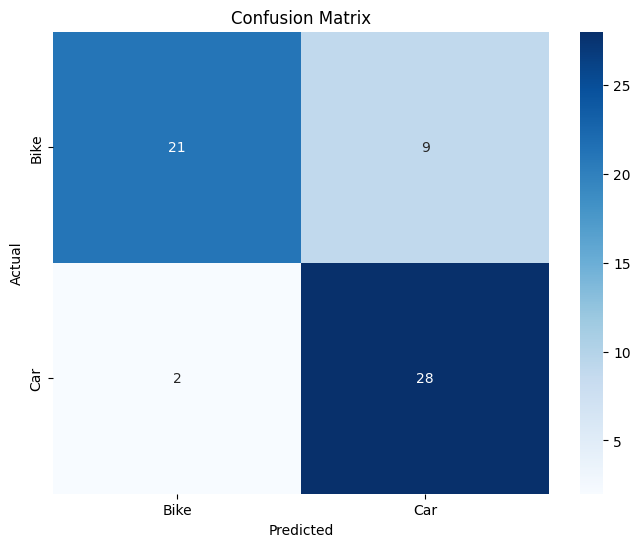

(0.8166666666666667,
 0.8349001175088131,
 0.8166666666666667,
 0.8141368628555337,
 array([[21,  9],
        [ 2, 28]]))

In [32]:
evaluate_model(model, val_loader)